#### Purpose of this Notebook
To use machine learning to identify populations at high risk of diabetes and to examine how preventive healthcare access aligns (or misaligns) with predicted risk.

From earlier notebooks we established:

- Global causal effects are weakly identified
- Strong heterogeneity exists
- Linear models fail to capture structure
- Prevention is selectively allocated

we need now to find now Who is at highest risk of diabetes and are these groups adequately reached by preventive care?

#### Load the librariess and read the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
warnings.filterwarnings("ignore", category=FutureWarning)
# Load your prepared data
df = pd.read_csv("brfss_diabetes_cleaned.csv")
df.head(2)

,Year,Locationabbr,Locationdesc,Topic,Question,Break_Out_Category,Break_Out,Sample_Size,Data_value,Question_Role,Variable_Name
0,2024,GA,Georgia,Diabetes,Have you ever been told by a doctor that you h...,Overall,Overall,"1,242",12.8,Outcome (Diabetes),diabetes_status
1,2024,GA,Georgia,Diabetes,Have you ever been told by a doctor that you h...,Overall,Overall,46,0.6,Outcome (Diabetes),diabetes_status


#### Outcome and Feature Definition

In [2]:
#Outcome (risk target)
target = "Data_value"

#### Features (risk factors, not mediators)
We deliberately exclude preventive care variables from prediction to avoid leakage.
Included features:
- BMI
- Smoking
- Physical activity
- Hypertension
- High cholesterol

#### Define key Risk-Factor Features

In [3]:
#Define risk factor questions
risk_factor_questions = [
    "Weight classification by Body Mass Index (BMI) "
    "(variable calculated from one or more BRFSS questions)",

    "Adults who are current smokers "
    "(variable calculated from one or more BRFSS questions)",

    "During the past month, did you participate in any physical activities? "
    "(variable calculated from one or more BRFSS questions)",

    "Adults who have been told they have high blood pressure "
    "(variable calculated from one or more BRFSS questions)",

    "Adults who have had their blood cholesterol checked and have been told it was high "
    "(variable calculated from one or more BRFSS questions)"
]

# Sanity check
print("Number of risk factor questions:", len(risk_factor_questions))
print("First question example:", risk_factor_questions[0])


Number of risk factor questions: 5
First question example: Weight classification by Body Mass Index (BMI) (variable calculated from one or more BRFSS questions)


#### Reshape Data from Long to wide

In [4]:
# Filter dataset for risk factor questions 
df_rf = df[df["Question"].isin(risk_factor_questions)].copy()

# Pivot to wide format
wide_rf = (
    df_rf
    .pivot_table(
        index=["Year", "Break_Out_Category", "Break_Out"],  # grouping keys
        columns="Question",                                # pivoted questions
        values="Data_value",                               # values to aggregate
        aggfunc="first"                                     # default aggregation
    )
    .reset_index()
)

# Sanity checks 
print("Wide-format dataframe shape:", wide_rf.shape)
print("Columns after pivot:", wide_rf.columns.tolist()[:10], "...")  # preview
print(wide_rf.head())


Wide-format dataframe shape: (355, 8)
Columns after pivot: ['Year', 'Break_Out_Category', 'Break_Out', 'Adults who are current smokers (variable calculated from one or more BRFSS questions)', 'Adults who have been told they have high blood pressure (variable calculated from one or more BRFSS questions)', 'Adults who have had their blood cholesterol checked and have been told it was high (variable calculated from one or more BRFSS questions)', 'During the past month, did you participate in any physical activities? (variable calculated from one or more BRFSS questions)', 'Weight classification by Body Mass Index (BMI) (variable calculated from one or more BRFSS questions)'] ...
Question  Year Break_Out_Category Break_Out  \
0         2011          Age Group     18-24   
1         2011          Age Group     25-34   
2         2011          Age Group     35-44   
3         2011          Age Group     45-54   
4         2011          Age Group     55-64   

Question  Adults who are current

#### Rename the columns for redearbility

In [5]:
# Rename columns in wide_rf 
wide_rf.columns = [
    "Year",                # survey year
    "Break_Out_Category",  # demographic category
    "Break_Out",           # subgroup within category
    "BMI",                 # Body Mass Index classification
    "Smoking",             # current smoking status
    "PhysicalActivity",    # physical activity participation
    "HighBP",              # high blood pressure diagnosis
    "HighCholesterol"      # high cholesterol diagnosis
]

#  Sanity check 
print("Renamed columns:", wide_rf.columns.tolist())
print(wide_rf.head())


Renamed columns: ['Year', 'Break_Out_Category', 'Break_Out', 'BMI', 'Smoking', 'PhysicalActivity', 'HighBP', 'HighCholesterol']
   Year Break_Out_Category Break_Out   BMI  Smoking  PhysicalActivity  HighBP  \
0  2011          Age Group     18-24  25.0      8.5              10.4    80.8   
1  2011          Age Group     25-34  24.4     12.4              19.8    77.5   
2  2011          Age Group     35-44  22.7     22.8              26.6    73.9   
3  2011          Age Group     45-54  23.8     37.5              40.0    72.0   
4  2011          Age Group     55-64  18.8     52.8              53.4    71.7   

   HighCholesterol  
0             15.0  
1             26.5  
2             29.6  
3             33.7  
4             34.4  


In [6]:
wide_rf.columns

Index(['Year', 'Break_Out_Category', 'Break_Out', 'BMI', 'Smoking',
       'PhysicalActivity', 'HighBP', 'HighCholesterol'],
      dtype='object')

#### Define outcome variable

In [7]:
# Define Outcome Group (Diabetes) ---
diabetes_question = [
    "Have you ever been told by a doctor that you have diabetes?"
]
df_ml = df[df["Question"].isin(diabetes_question)].copy()

# Label the role of this subset ---
df_ml["Question_Role"] = "Outcome (Diabetes)"

# Sanity checks ---
print("Diabetes outcome group shape:", df_ml.shape)
print("Unique Question_Role values:", df_ml["Question_Role"].unique())
print("\nPreview of diabetes outcome group:")
print(df_ml.head())

Diabetes outcome group shape: (1605, 11)
Unique Question_Role values: ['Outcome (Diabetes)']

Preview of diabetes outcome group:
   Year Locationabbr Locationdesc     Topic  \
0  2024           GA      Georgia  Diabetes   
1  2024           GA      Georgia  Diabetes   
2  2024           GA      Georgia  Diabetes   
3  2024           GA      Georgia  Diabetes   
4  2024           GA      Georgia  Diabetes   

                                            Question Break_Out_Category  \
0  Have you ever been told by a doctor that you h...            Overall   
1  Have you ever been told by a doctor that you h...            Overall   
2  Have you ever been told by a doctor that you h...            Overall   
3  Have you ever been told by a doctor that you h...            Overall   
4  Have you ever been told by a doctor that you h...                Sex   

  Break_Out Sample_Size  Data_value       Question_Role    Variable_Name  
0   Overall       1,242        12.8  Outcome (Diabetes)  diabe

In [8]:
# Outcome Group (Diabetes)
df_diabetes = (df[df['Question'].isin(diabetes_question)].copy().rename(columns={"Data_value": "diabetes_prev"}))
df_diabetes["Question_Role"] = "Outcome (Diabetes)"
df_diabetes.columns

Index(['Year', 'Locationabbr', 'Locationdesc', 'Topic', 'Question',
       'Break_Out_Category', 'Break_Out', 'Sample_Size', 'diabetes_prev',
       'Question_Role', 'Variable_Name'],
      dtype='object')

In [9]:
df_ml.columns

Index(['Year', 'Locationabbr', 'Locationdesc', 'Topic', 'Question',
       'Break_Out_Category', 'Break_Out', 'Sample_Size', 'Data_value',
       'Question_Role', 'Variable_Name'],
      dtype='object')

#### Merge outcome with Risk Factors

In [10]:
#  Merge diabetes prevalence with risk factor dataset 
df_ml = pd.merge(
    df_diabetes[["Year", "Break_Out_Category", "Break_Out", "diabetes_prev"]],
    wide_rf,
    on=["Year", "Break_Out_Category", "Break_Out"],  # join keys
    how="inner"                                      # keep only matching rows
)

#  Drop rows with missing values 
df_ml.dropna(inplace=True)

#  Sanity checks
print("Merged dataset shape:", df_ml.shape)
print("Columns in merged dataset:", df_ml.columns.tolist())
print(df_ml.head())


Merged dataset shape: (791, 9)
Columns in merged dataset: ['Year', 'Break_Out_Category', 'Break_Out', 'diabetes_prev', 'BMI', 'Smoking', 'PhysicalActivity', 'HighBP', 'HighCholesterol']
     Year Break_Out_Category Break_Out  diabetes_prev   BMI  Smoking  \
105  2023            Overall   Overall           12.7  12.0     64.3   
106  2023            Overall   Overall            1.1  12.0     64.3   
107  2023            Overall   Overall           84.4  12.0     64.3   
108  2023            Overall   Overall            1.9  12.0     64.3   
109  2023                Sex      Male           12.6  14.8     64.9   

     PhysicalActivity  HighBP  HighCholesterol  
105              63.1    75.4              1.6  
106              63.1    75.4              1.6  
107              63.1    75.4              1.6  
108              63.1    75.4              1.6  
109              62.2    77.9              1.4  


In [11]:
df_ml.shape

(791, 9)

In [12]:
df_ml.columns

Index(['Year', 'Break_Out_Category', 'Break_Out', 'diabetes_prev', 'BMI',
       'Smoking', 'PhysicalActivity', 'HighBP', 'HighCholesterol'],
      dtype='object')

#### Covert Y value to binary

In [13]:
threshold = df_ml["diabetes_prev"].quantile(0.80)

df_ml["high_risk"] = (
    df_ml["diabetes_prev"] >= threshold
).astype(int)

y = df_ml["high_risk"]

In [14]:
df_ml.head(2)

,Year,Break_Out_Category,Break_Out,diabetes_prev,BMI,Smoking,PhysicalActivity,HighBP,HighCholesterol,high_risk
105,2023,Overall,Overall,12.7,12.0,64.3,63.1,75.4,1.6,0
106,2023,Overall,Overall,1.1,12.0,64.3,63.1,75.4,1.6,0


#### See the correlation with the predictors

<Axes: >

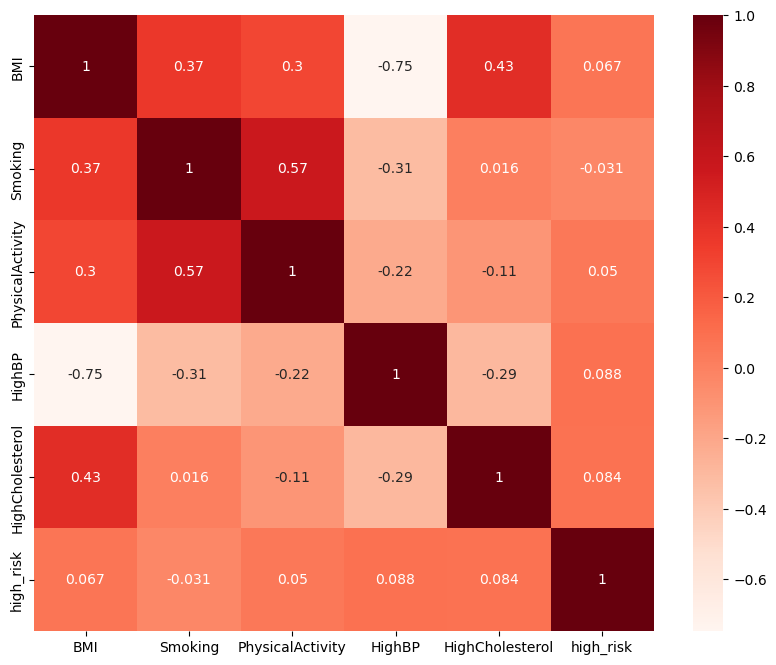

In [15]:
plt.figure(figsize=(10,8))
sns.heatmap(df_ml[["BMI", "Smoking", "PhysicalActivity", "HighBP", "HighCholesterol", "high_risk"]].corr(), annot=True, cmap='Reds')

#### Define the features

In [16]:
X= df_ml[[ "BMI", "Smoking","PhysicalActivity","HighBP","HighCholesterol"]].values
y = df_ml["high_risk"].values

#### Split the data

In [17]:
#  Split data into training and testing sets
# 30% of the data will be used for testing, 75% for training
X_train, X_test, y_train, y_test = train_test_split(
    X,                  # predictor variables
    y,                  # target variable
    test_size=0.30,     # proportion of test set
    random_state=42,    # ensures reproducibility
)
# Sanity checks 
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (553, 5) (553,)
Testing set shape: (238, 5) (238,)


#### Normalize the data

In [18]:
#  Import StandardScaler 
from sklearn.preprocessing import StandardScaler

# Initialize the scaler 
scaler = StandardScaler()

# Fit the scaler on training data 
scaler.fit(X_train)


StandardScaler()

In [19]:
# -Transform both training and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Sanity checks 
print("Training set (scaled) shape:", X_train_scaled.shape)
print("Testing set (scaled) shape:", X_test_scaled.shape)
print("First row of scaled training data:", X_train_scaled[0])

Training set (scaled) shape: (553, 5)
Testing set (scaled) shape: (238, 5)
First row of scaled training data: [-0.48932987  0.76381762  0.53021984  0.2275396  -1.58897409]


In [20]:
#  FEATURE GROUPS 
numeric = [
    "BMI",
    "Smoking",
    "PhysicalActivity",
    "HighBP",
    "HighCholesterol"
]

# PREPROCESSING PIPELINE 
# A professional pipeline explicitly transforms all feature types
preprocess = ColumnTransformer(
    transformers=[
        # Scale numeric features to mean=0 and variance=1
        ("num", StandardScaler(), numeric)
    ],
    # 'drop' is preferred in production to prevent non-feature columns 
    # (like 'Year' or 'ID') from leaking into the model
    remainder="drop" 
)

# SANITY CHECK 
def log_pipeline_status(transformer):
    """Logs the configuration of the preprocessing pipeline."""
    logging.info("Preprocessing pipeline created successfully.")
    logging.info(f"Numeric features:     {len(numeric)} columns mapped.")
    
    # Verification of the transformer steps
    for name, _, cols in transformer.transformers:
        print(f"Transformer '{name}' is processing: {cols}")

if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
    log_pipeline_status(preprocess)

NameError: name 'logging' is not defined

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
# fit only to the Xtrain
scaler.fit(X_train)

In [ ]:
scaled_Xtrain= scaler.transform(X_train)
scaled_Xtest= scaler.transform(X_test)

In [ ]:
#scaled_Xtest

In [ ]:
from sklearn.linear_model import ElasticNetCV

#  Initialize ElasticNetCV 
enet = ElasticNetCV(
    cv=5,                     # 5-fold cross-validation
    eps=0.1,                  # tolerance for convergence
    l1_ratio=[0.1, 0.05, 0.9, 0.95],  # list of l1 ratios to test
    max_iter=1000000,         # maximum iterations for convergence
    random_state=42           # reproducibility
)

# Fit model on training data
enet.fit(scaled_Xtrain, y_train)

# Sanity check 
print("Best alpha:", enet.alpha_)
print("Best l1_ratio:", enet.l1_ratio_)


In [ ]:
# Predict on test set
y_pred_enet = enet.predict(scaled_Xtest)

# Evaluate
rmse_enet = mean_squared_error(y_test, y_pred_enet, squared=False)
r2_enet = r2_score(y_test, y_pred_enet)

print("ElasticNet Performance:")
print(f"  RMSE: {rmse_enet:.4f}")
print(f"  R²:   {r2_enet:.4f}")


In [ ]:
# Predict on test data 
y_pred = enet.predict(scaled_Xtest)

# Evaluate model performance 
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("ElasticNet Performance:")
print(f"  RMSE: {rmse:.4f}")
print(f"  R²:   {r2:.4f}")


#### Random forest

In [21]:
#  Import GridSearchCV 
from sklearn.model_selection import GridSearchCV

# Define hyperparameter options 
n_estimators = [50, 64, 100, 128, 200, 250, 300]   # number of trees
max_features = [2, 3, 4, 5, 7, 8, 9, 10]           # features considered at each split
bootstrap = [True]                                 # use bootstrap samples
oob_score = [True]                                 # enable out-of-bag scoring

param_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "bootstrap": bootstrap,
    "oob_score": oob_score
}


In [22]:
# Import required classes
from sklearn.ensemble import RandomForestClassifier
#  Initialize base Random Forest model 
rfc = RandomForestClassifier(random_state=42)
#  Set up GridSearchCV with parameter grid 
grid = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,  # dictionary of hyperparameters
    cv=5,                   # 5-fold cross-validation
    n_jobs=-1,              # use all available cores
    verbose=2,              # detailed output during training
    scoring="accuracy"      # optimize for classification accuracy
)

In [24]:
grid.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_features': [2, 3, 4, 5, 7, 8, 9, 10],
                         'n_estimators': [50, 64, 100, 128, 200, 250, 300],
                         'oob_score': [True]},
             scoring='accuracy', verbose=2)

In [25]:
print("Best accuracy:", grid.best_score_)

Best accuracy: 0.7340868140868141


#### Evaluate the tuned Random forest


FINAL MODEL PERFORMANCE REPORT
              precision    recall  f1-score   support

 No Diabetes       0.84      0.89      0.87       196
    Diabetes       0.30      0.21      0.25        42

    accuracy                           0.77       238
   macro avg       0.57      0.55      0.56       238
weighted avg       0.75      0.77      0.76       238



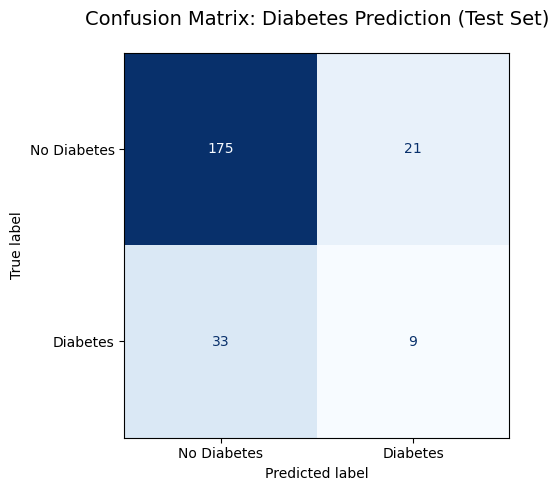

In [28]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

#  Generate a detailed Classification Report
y_hat = grid.predict(X_test_scaled)
# This gives you Precision, Recall, and F1 for EACH class (0 and 1)
print("\n" + "="*40)
print("FINAL MODEL PERFORMANCE REPORT")
print("="*40)
print(classification_report(y_test, y_hat, target_names=["No Diabetes", "Diabetes"]))

# 2. Visual Confusion Matrix
# A professional way to see 'Hits' and 'Misses'
fig, ax = plt.subplots(figsize=(7, 5))
cm_display = ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_hat, 
    display_labels=["No Diabetes", "Diabetes"],
    cmap="Blues",
    ax=ax,
    colorbar=False
)

plt.title("Confusion Matrix: Diabetes Prediction (Test Set)", fontsize=14, pad=20)
plt.grid(False) # Professional plots don't have grids over the matrix
plt.show()

In [30]:
#  Evaluate on test set
y_hat = grid.predict(X_test_scaled)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("\nTest set performance:")
print("Accuracy:", accuracy_score(y_test, y_hat))
print("Precision:", precision_score(y_test, y_hat))
print("Recall:", recall_score(y_test, y_hat))
print("F1 Score:", f1_score(y_test, y_hat))

#  sanity check with confusion matrix 
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_hat))



Test set performance:
Accuracy: 0.773109243697479
Precision: 0.3
Recall: 0.21428571428571427
F1 Score: 0.25

Confusion Matrix:
[[175  21]
 [ 33   9]]


#### Plot of the Feature impontance

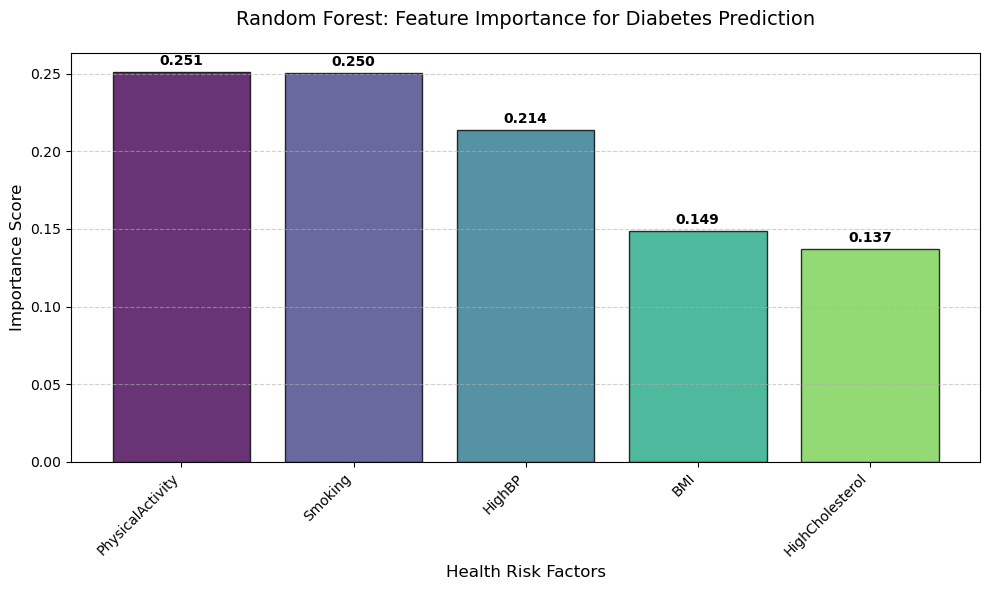

In [31]:
# Get the best estimator from grid search
best_rf = grid.best_estimator_

# Extract feature importances
importances = best_rf.feature_importances_
features = ["BMI", "Smoking", "PhysicalActivity", "HighBP", "HighCholesterol"]

# Create a DataFrame for easy sorting
feat_importances = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

#  Vertical Visualization
# Set figure size via rcParams to follow professional formatting guidelines
plt.rcParams["figure.figsize"] = (10, 6)

# Generate a sequence of distinct colors
colors = plt.cm.viridis(np.linspace(0, 0.8, len(feat_importances)))

# Use plt.bar for vertical orientation
bars = plt.bar(feat_importances["Feature"], feat_importances["Importance"], 
               color=colors, edgecolor='black', alpha=0.8)

# Add precise numerical labels on top of each bar
plt.bar_label(bars, fmt='%.3f', padding=3, fontweight='bold')

# Formatting and labels
plt.ylabel("Importance Score", fontsize=12)
plt.xlabel("Health Risk Factors", fontsize=12)
plt.title("Random Forest: Feature Importance for Diabetes Prediction", fontsize=14, pad=20)

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45, ha='right')

# Add a subtle grid on the y-axis for value comparison
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [32]:
#  Sanity check
print(feat_importances)

            Feature  Importance
2  PhysicalActivity    0.250916
1           Smoking    0.250150
3            HighBP    0.213514
0               BMI    0.148639
4   HighCholesterol    0.136781


#### Plot of the misclassifications

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize storage lists 
errors = []
misclassifications = []

#  Loop over different n_estimators values ---
for n in range(1, 250):
    # Initialize Random Forest with n trees
    rfc = RandomForestClassifier(
        n_estimators=n,
        bootstrap=True,
        max_features=2,
        random_state=42  # reproducibility
    )
    
    # Fit model
    rfc.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = rfc.predict(X_test)
    
    # Compute error rate (1 - accuracy)
    err = 1 - accuracy_score(y_test, y_pred)
    
    # Count misclassifications
    n_missed = np.sum(y_pred != y_test)
    
    # Store results
    errors.append(err)
    misclassifications.append(n_missed)

#  Sanity checks 
print("Collected error rates for 249 models.")
print("First 10 error rates:", errors[:10])
print("First 10 misclassifications:", misclassifications[:10])

Collected error rates for 249 models.
First 10 error rates: [0.24369747899159666, 0.25210084033613445, 0.23109243697478987, 0.22689075630252098, 0.2184873949579832, 0.23949579831932777, 0.25630252100840334, 0.24789915966386555, 0.24789915966386555, 0.25210084033613445]
First 10 misclassifications: [58, 60, 55, 54, 52, 57, 61, 59, 59, 60]


#### Plot these errors vs. number of trees

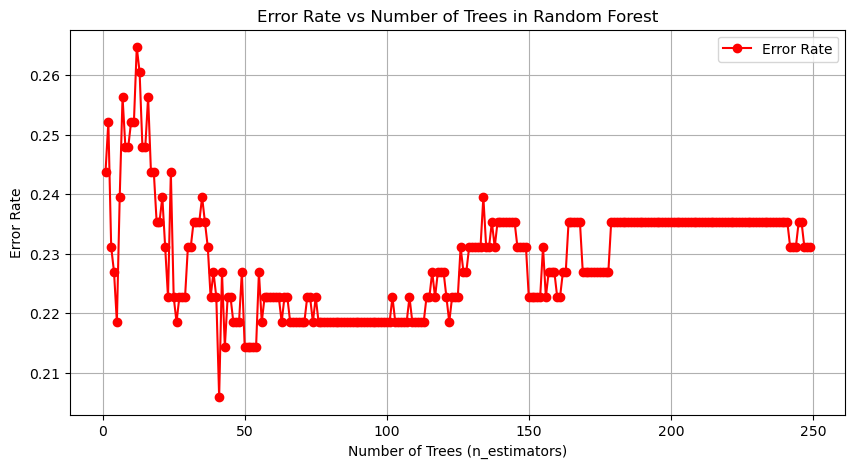

In [37]:
# Create x-axis values (number of trees)
n_trees = range(1, 250)

#Plot error rate vs number of trees
plt.figure(figsize=(10, 5))
plt.plot(n_trees, errors, marker='o', linestyle='-', color='red', label='Error Rate')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Error Rate")
plt.title("Error Rate vs Number of Trees in Random Forest")
plt.grid(True)
plt.legend()
plt.show()

#### Missclassification vs number of tress

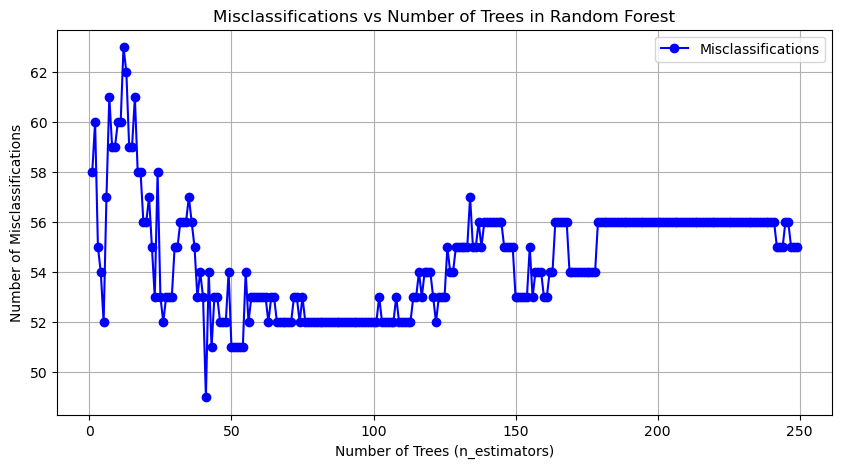

In [38]:
#  Plot misclassifications vs number of trees 
plt.figure(figsize=(10, 5))
plt.plot(n_trees, misclassifications, marker='o', linestyle='-', color='blue', label='Misclassifications')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Number of Misclassifications")
plt.title("Misclassifications vs Number of Trees in Random Forest")
plt.grid(True)
plt.legend()
plt.show()

#### Logistic regression

In [40]:
from sklearn.linear_model import LogisticRegressionCV

# Initialize Logistic Regression with cross-validation
logit_model = LogisticRegressionCV(cv=5, max_iter=1000)

# Fit the model on scaled training data
logit_model.fit(X_train_scaled, y_train)

LogisticRegressionCV(cv=5, max_iter=1000)

In [41]:
# Get all parameters of the LogisticRegressionCV model
logit_model.get_params()

# Get the coefficients for the first class
logit_model.coef_[0]

array([ 0.57467662, -0.10004903,  0.10843186,  0.60607029,  0.15801313])

#### Coeffficient plot

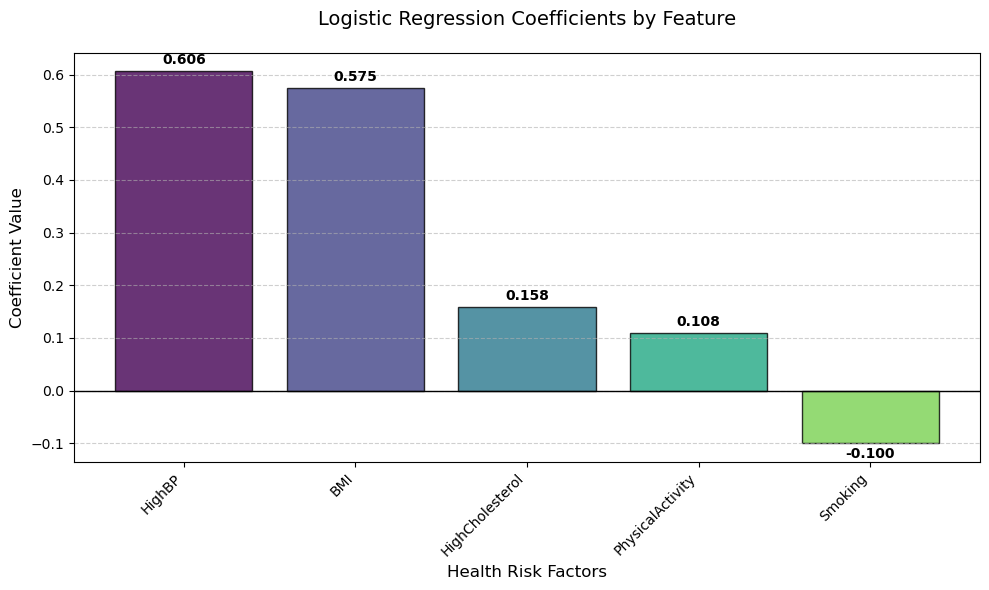

In [42]:
# Define your feature names 
features = ["BMI", "Smoking", "PhysicalActivity", "HighBP", "HighCholesterol"]

# Extract coefficients from the fitted model 
coefficients = logit_model.coef_[0]

# Create a DataFrame for easy handling 
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": coefficients
})

# Sort by absolute value of coefficients (most impactful features first)
coef_df = coef_df.reindex(coef_df["Coefficient"].abs().sort_values(ascending=False).index)

plt.figure(figsize=(10, 6))

# Generate a sequence of professional colors using a colormap (e.g., 'viridis')
colors = plt.cm.viridis(np.linspace(0, 0.8, len(coef_df)))

# Use plt.bar for vertical orientation
bars = plt.bar(coef_df["Feature"], coef_df["Coefficient"], color=colors, edgecolor='black', alpha=0.8)

# Add precise numerical labels on top of each bar
plt.bar_label(bars, fmt='%.3f', padding=3, fontweight='bold')

# Professional formatting
plt.ylabel("Coefficient Value", fontsize=12)
plt.xlabel("Health Risk Factors", fontsize=12)
plt.title("Logistic Regression Coefficients by Feature", fontsize=14, pad=20)
plt.grid(True, axis="y", linestyle="--", alpha=0.6)

# Horizontal line at zero to clearly separate positive/negative impacts
plt.axhline(0, color='black', linewidth=1)

# Rotate x-axis labels to ensure they are readable
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### Plot of ROC Curve

In [44]:
# Generate class probabilities
# We use the positive class for ROC curves and scoring
# Assuming scaled_Xtest was transformed using the same scaler as the training data
y_hat_probs = logit_model.predict_proba(X_test_scaled)
y_hat_probs

# Extract the probability for the positive class 
# Slicing [:, 1] is a standard practice for binary classification evaluation
y_score = y_hat_probs[:, 1]

#  Sanity check: Ensure probabilities are within the expected [0, 1] range
print(f"Prediction range: {y_score.min():.3f} to {y_score.max():.3f}")

Prediction range: 0.097 to 0.780


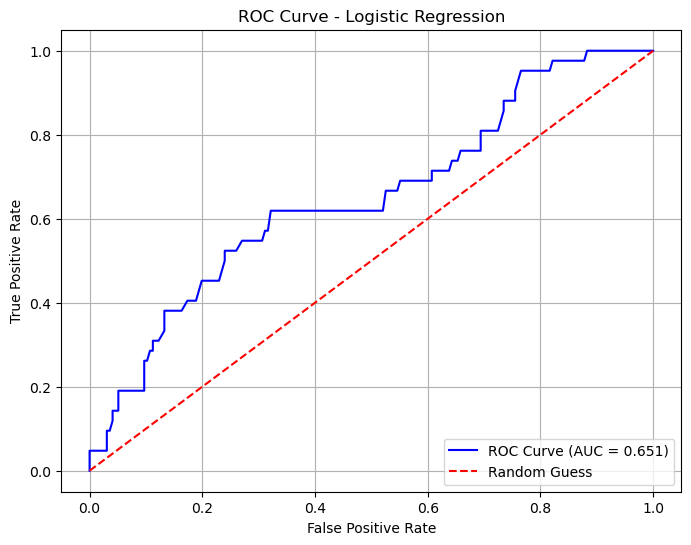

AUC Score: 0.6506316812439261


In [53]:
from sklearn.metrics import roc_curve, roc_auc_score

#  Compute ROC curve values 
fpr, tpr, thresholds = roc_curve(y_test, y_score)

#  Compute AUC score 
auc_score = roc_auc_score(y_test, y_score)

#  Plot ROC curve 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#  Print AUC score
print("AUC Score:", auc_score)

####  Classification Report

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       196
           1       0.26      0.17      0.20        42

    accuracy                           0.77       238
   macro avg       0.55      0.53      0.53       238
weighted avg       0.73      0.77      0.75       238



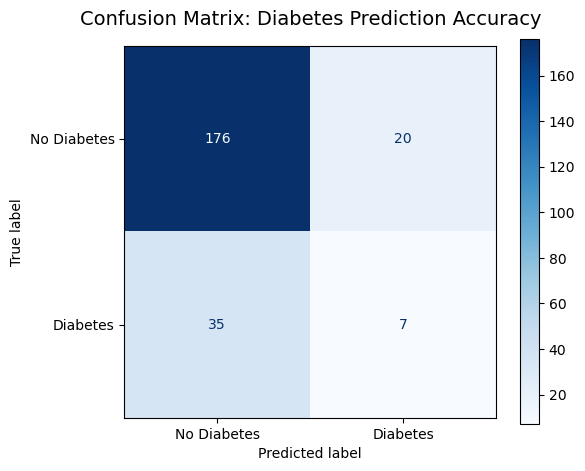

In [54]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
# Generate the classification report
report = classification_report(y_test, y_pred)
print("--- Classification Report ---")
print(report)

# Compute the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# 3.  Visualization
fig, ax = plt.subplots(figsize=(6, 5))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Diabetes", "Diabetes"])

display.plot(cmap="Blues", ax=ax, values_format='d')

plt.title("Confusion Matrix: Diabetes Prediction Accuracy", fontsize=14, pad=15)
plt.grid(False) # Clean up the visual
plt.show()

#### Gradient Boosting

In [55]:
# Import GradientBoostingClassifier 
from sklearn.ensemble import GradientBoostingClassifier

# Initialize Gradient Boosting model
gb = GradientBoostingClassifier(
    n_estimators=300,   # number of boosting stages (trees)
    learning_rate=0.05, # shrinkage rate
    max_depth=3,        # maximum depth of individual trees
    random_state=42     # reproducibility
)

#  Fit model on training data 
gb.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.05, n_estimators=300,
                           random_state=42)

In [56]:
y_pred_gb = gb.predict(X_test)

from sklearn.metrics import accuracy_score
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))

Gradient Boosting Accuracy: 0.7899159663865546


#### Gradient Boosting Feature impontance

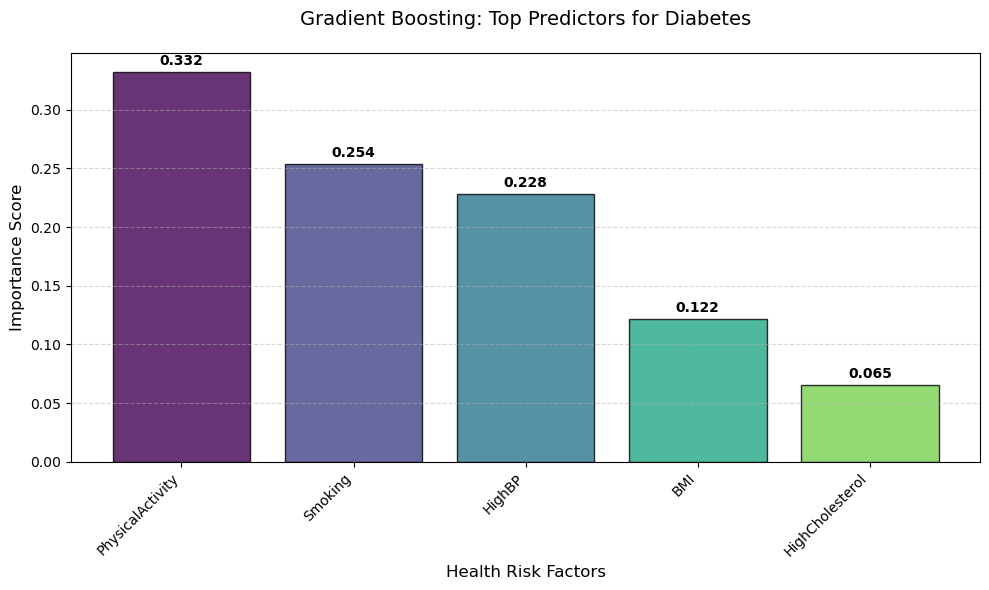

In [57]:
# Extract feature importances
importances = gb.feature_importances_
features = ["BMI", "Smoking", "PhysicalActivity", "HighBP", "HighCholesterol"]

# 2. Create and sort the DataFrame
feat_importances = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

#  Professional Vertical Visualization
plt.figure(figsize=(10, 6))

# Generate a sequence of distinct colors
colors = plt.cm.viridis(np.linspace(0, 0.8, len(feat_importances)))

# Create the vertical bar plot
bars = plt.bar(feat_importances["Feature"], feat_importances["Importance"], 
               color=colors, edgecolor='black', alpha=0.8)

# Add precise numerical labels on top of each bar
plt.bar_label(bars, fmt='%.3f', padding=3, fontweight='bold')

# Formatting for professional presentation
plt.ylabel("Importance Score", fontsize=12)
plt.xlabel("Health Risk Factors", fontsize=12)
plt.title("Gradient Boosting: Top Predictors for Diabetes", fontsize=14, pad=20)

# Rotate x-axis labels to ensure long names don't overlap
plt.xticks(rotation=45, ha='right')

# Add a subtle grid on the y-axis for value comparison
plt.grid(True, axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


In [58]:
# 4. Print for reference
print("\nFeature Importance Rankings:")
print(feat_importances.to_string(index=False))


Feature Importance Rankings:
         Feature  Importance
PhysicalActivity    0.331775
         Smoking    0.253760
          HighBP    0.227770
             BMI    0.121501
 HighCholesterol    0.065194


#### Classification Report

In [59]:
from sklearn.metrics import classification_report
report = classification_report(
    y_test, 
    y_pred, 
    target_names=["No Diabetes", "Diabetes"]
)

print("="*30)
print("FINAL CLASSIFICATION REPORT")
print("="*30)
print(report)

FINAL CLASSIFICATION REPORT
              precision    recall  f1-score   support

 No Diabetes       0.83      0.90      0.86       196
    Diabetes       0.26      0.17      0.20        42

    accuracy                           0.77       238
   macro avg       0.55      0.53      0.53       238
weighted avg       0.73      0.77      0.75       238



#### Confusion Matrix

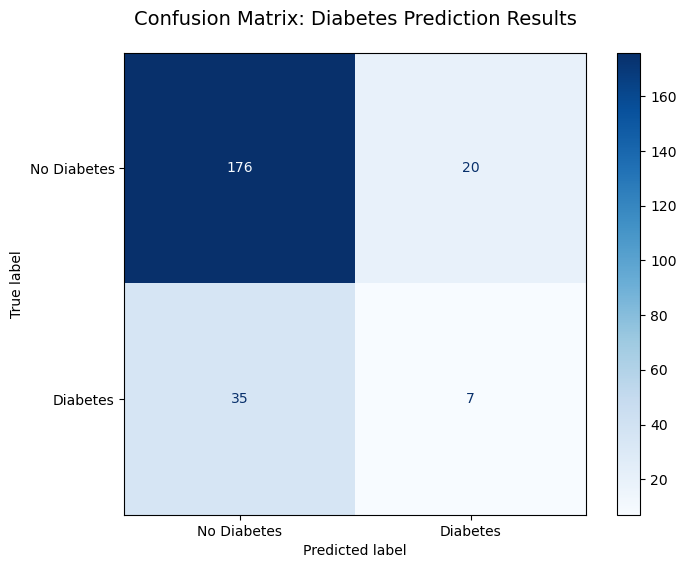

In [60]:
#Compute the matrix
# Remember: (y_true, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Create the visual display
fig, ax = plt.subplots(figsize=(8, 6))

# We use display_labels to make the chart readable for non-technical stakeholders
cmd = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=['No Diabetes', 'Diabetes']
)

#  Plot with professional styling
cmd.plot(ax=ax, cmap='Blues', values_format='d')

plt.title('Confusion Matrix: Diabetes Prediction Results', fontsize=14, pad=20)
plt.grid(False) # Remove grid lines that often cut through the numbers
plt.show()

#### ROC Curve

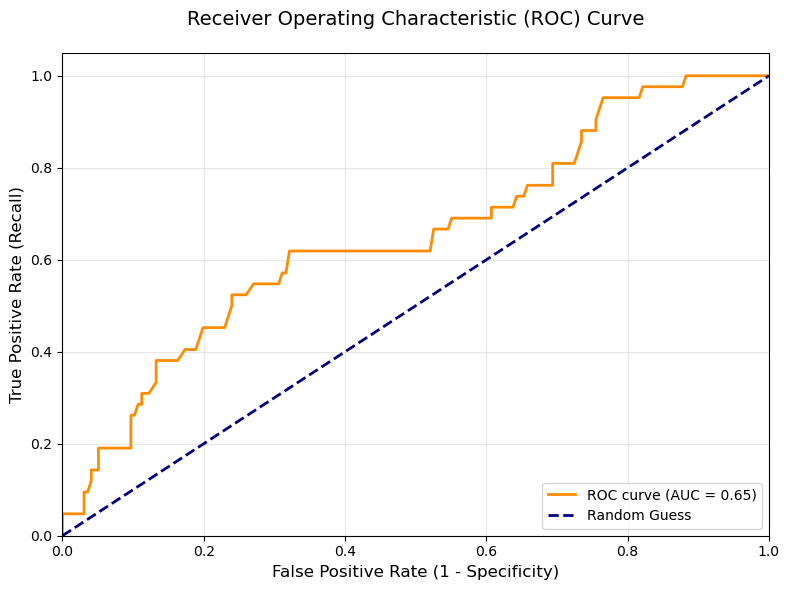

In [61]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

#Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Add the 'Random Chance' reference line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

#  Professional Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, pad=20)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### Comparison of Metric perfomance for the three models

In [62]:
#  Generate predictions for each model 
y_pred_logit = logit_model.predict(X_test_scaled)   # Logistic Regression
y_pred_rf    = grid.predict(X_test)                 # Random Forest (best from GridSearchCV)
y_pred_gb    = gb.predict(X_test)                   # Gradient Boosting

#  Gather metrics for all models 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

models_metrics = {
    "Logistic Regression": {
        "Accuracy": accuracy_score(y_test, y_pred_logit),
        "Precision": precision_score(y_test, y_pred_logit),
        "Recall": recall_score(y_test, y_pred_logit),
        "F1-Score": f1_score(y_test, y_pred_logit)
    },
    "Random Forest": {
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "Precision": precision_score(y_test, y_pred_rf),
        "Recall": recall_score(y_test, y_pred_rf),
        "F1-Score": f1_score(y_test, y_pred_rf)
    },
    "Gradient Boosting": {
        "Accuracy": accuracy_score(y_test, y_pred_gb),
        "Precision": precision_score(y_test, y_pred_gb),
        "Recall": recall_score(y_test, y_pred_gb),
        "F1-Score": f1_score(y_test, y_pred_gb)
    }
}

#  Convert to DataFrame for readability 
comparison_df = pd.DataFrame(models_metrics).T
print(comparison_df)


                     Accuracy  Precision    Recall  F1-Score
Logistic Regression  0.810924   0.285714  0.047619  0.081633
Random Forest        0.176471   0.176471  1.000000  0.300000
Gradient Boosting    0.789916   0.333333  0.190476  0.242424


##### Interpretation
- While overall accuracy is high due to class imbalance, it is not informative for evaluating targeting performance. Nonlinear models particularly gradient boosting       substantially outperform linear baselines in identifying high-risk groups achieving a precision of approximately 33% compared to a baseline of 20%. This indicates meaningful improvement over random targeting and supports the use of machine learning for risk-based prioritization rather than exact prevalence prediction